# BEST PLACES TO LIVE IN CITY OF NEWCASTLE, NEW SOUTH WALES, AUSTRALIA

In [1]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import urllib.request # import the library we use to open URLs
from bs4 import BeautifulSoup # import the library we use to parse website

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import geocoder # import geocoder
import folium # map rendering library

import geopandas as gdp # read shapefile

from selenium import webdriver # automation of input into the web
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait

import re # regrex
from time import sleep

print('Libraries imported.')

Libraries imported.


## PART I: ACHIEVE ALL SUBURBS IN CITY OF NEWCASTLE FROM WIKIPEDIA PAGE

In [2]:
# parse the wikipedia web page
url = "https://en.wikipedia.org/wiki/List_of_suburbs_in_Greater_Newcastle,_New_South_Wales"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')

In [3]:
# Create list to store name of the extracted suburbs
hunter_suburbs = []

for anchor in soup.find_all('a', href=True):
    title = anchor.get('title')
    if 'New South Wales' in str(title):
        hunter_suburbs.append(str(title))

In [4]:
# Format and clean the name of suburbs 
for i, v in enumerate(hunter_suburbs):
    hunter_suburbs[i] = v.replace(', New South Wales','')\
    .replace(' (New South Wales)','')\
    .replace(' (Lake Macquarie)','')\
    .replace(' (page does not exist)','')

In [5]:
# Remove the first row 
# Remove other suburbs not in the City of Newcastle
# hunter_suburbs.index('Wickham') # 51 - Index of the last listed suburb, Wickham
hunter_suburbs = hunter_suburbs[1:52]

In [6]:
# Store the suburbs and state: New South Wales (NSW) into a dataframe
hunter=pd.DataFrame(hunter_suburbs,columns=['Suburb'])
hunter['State']='NSW'

# hunter['Suburb'].value_counts()

## PART II: ACHIEVE THE POSTCODE OF RELEVANT SUBURBS

In [7]:
# The original SQL file was downloaded from: https://gist.github.com/randomecho/5020859
# Data was then exported to CSV file and uploaded to public

# Download the uploaded file
!wget -q -O 'Australia_PostalCode.csv' https://www.dropbox.com/s/2n84mr8pxmpx38m/Australia_PostalCode.csv?dl=0
print('Data downloaded!')

Data downloaded!


In [8]:
# Read the file into a dataframe 
aus_postcode = pd.read_csv('Australia_PostalCode.csv')
aus_postcode.head()

,id,postcode,suburb,state,latitude,longitude
0,1,200,Australian National University,ACT,-35.28,149.12
1,2,221,Barton,ACT,-35.20,149.10
2,3,800,Darwin,NT,-12.80,130.96
3,4,801,Darwin,NT,-12.80,130.96
4,5,804,Parap,NT,-12.43,130.84


In [9]:
# Merge the two dataframe to get one with both names and postcodes of all suburbs in the City of Newcastle
df = pd.merge(hunter, aus_postcode,how='left',left_on=['Suburb','State'], right_on = ['suburb','state'])

In [10]:
# Drop unncessary columns
df.drop(['id','suburb','state','State','latitude','longitude'],axis=1,inplace=True)

# Fill NA values as 0 to apply the filtering options later
df["postcode"] = df["postcode"].fillna(0.0).astype(int)

In [11]:
# Filter the merged data to have the correct suburbs based on the range of postcode
df = df[(df['postcode'] < 2350) & (df['postcode'] > 2200)]

# There are some popular suburb names need to determine and drop the incorrect ones
df = df.drop(df[(df['Suburb']=='Carrington') & \
                           (df['postcode']==2324)].index)
# df = df.drop(df[(df['Suburb']=='Hillsborough') & \
#                            (df['postcode']==2320)].index) # In case of City of Macquarie

# df['Suburb'].value_counts()

In [12]:
# Check any difference between two sets to ensure the two dataframe have the same suburbs
print(list(set(list(hunter['Suburb'])) - set(list(df['Suburb']))))
print(list(set(list(df['Suburb'])) - set(list(hunter['Suburb']))))

[]
[]


## PART III: ACHIEVE THE LOCATIONS OF EACH SUBURBS USING GEOCODER

In [13]:
# The orginal exported data from SQL script actually includes latitude and longitude of each subrb. However the locations of several suburbs are wrong
# Instead I generate the locations of each suburb using Geocoder.arcgis

In [14]:
# initialize variable to None
lat_lng_coords = None
lat_coords = []
long_coords = []

# loop until the coordinates was generated
for index, row in df.iterrows():
    while(lat_lng_coords is None):
        g = geocoder.arcgis(('{}' + ', New South Wales, AU').format(row['postcode']))
        lat_lng_coords = g.latlng
        lat_coords.append(lat_lng_coords[0])
        long_coords.append(lat_lng_coords[1])
    lat_lng_coords = None

In [15]:
# Store the coordinates into the exsiting df dataframe
df['Latitude'] = lat_coords
df['Longitude'] = long_coords
df = df.reset_index()
df.head()

,index,Suburb,postcode,Latitude,Longitude
0,0,Adamstown,2289,-32.94514,151.698713
1,1,Adamstown Heights,2289,-32.94514,151.698713
2,2,Bar Beach,2300,-32.92955,151.779337
3,3,Beresfield,2322,-32.81035,151.629323
4,4,Birmingham Gardens,2287,-32.89368,151.655336


## PART IV: EXAMINE THE LIFE STYLE OF SUBURBS IN THE CITY OF NEWCASTLE USING K-MEANS CLUSTERING ALGORITHM

In [16]:
# create map of Newcastle with suburbs and their corresponding coordinates
# Latitude -32.9 and longitude 151.7 was used to create the map
latitude = -32.9
longitude = 151.7

map_new = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new)  
    
map_new

In [17]:
# Test credential with provided client id and secret from Foursquare Developer Site
CLIENT_ID = 'IILM0AQZ5XZZXZ1B2PUPCAXUY5FEF5MJHFUMMSIS1SYEPLWY' # your Foursquare ID
CLIENT_SECRET = 'XYO2SAZ5XQ5DSJGH5LLOG4E1AWQSHKGDY2U0J3C0TDZWDXWW' # your Foursquare Secret
VERSION = '20191010'
LIMIT = 100 # limit of number of venues returned by Foursquare API

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IILM0AQZ5XZZXZ1B2PUPCAXUY5FEF5MJHFUMMSIS1SYEPLWY
CLIENT_SECRET:XYO2SAZ5XQ5DSJGH5LLOG4E1AWQSHKGDY2U0J3C0TDZWDXWW


In [18]:
# Creat the function to get all near by venues of all suburbs with provided coordinates
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# Store the list of venues in a dataframe
df_venues = getNearbyVenues(names=df['Suburb'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Adamstown
Adamstown Heights
Bar Beach
Beresfield
Birmingham Gardens
Black Hill
Broadmeadow
Callaghan
Carrington
Cooks Hill
Elermore Vale
Fletcher
Georgetown
Hamilton
Hamilton East
Hamilton North
Hamilton South
Hexham
The Hill
Islington
Jesmond
The Junction
Kotara
Lambton
Lenaghan
Maryland
Maryville
Mayfield
Mayfield East
Mayfield North
Mayfield West
Merewether
Merewether Heights
Minmi
New Lambton
New Lambton Heights
Newcastle
Newcastle East
Newcastle West
North Lambton
Rankin Park
Sandgate
Shortland
Stockton
Tarro
Tighes Hill
Wallsend
Warabrook
Waratah
Waratah West
Wickham


In [20]:
# Group by Suburb
df_venues.groupby('Suburb').count()
df_venues

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adamstown,-32.945140,151.698713,Dan Murphy's,-32.940518,151.708296,Liquor Store
1,Adamstown,-32.945140,151.698713,Apple Charlestown,-32.963910,151.694124,Electronics Store
2,Adamstown,-32.945140,151.698713,Blackbutt Reserve,-32.937156,151.698399,Zoo
3,Adamstown,-32.945140,151.698713,Adams Ribs & Pizza,-32.934490,151.729330,Pizza Place
4,Adamstown,-32.945140,151.698713,Grill'd,-32.941345,151.711204,Burger Joint
...,...,...,...,...,...,...,...
3321,Wickham,-32.916397,151.756145,7-Eleven,-32.901160,151.741807,Convenience Store
3322,Wickham,-32.916397,151.756145,Subway,-32.899310,151.740030,Sandwich Place
3323,Wickham,-32.916397,151.756145,Domino's Pizza,-32.934716,151.725785,Pizza Place
3324,Wickham,-32.916397,151.756145,KFC,-32.902499,151.743274,Fast Food Restaurant


In [21]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 104 uniques categories.


In [22]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb column back to dataframe
df_onehot['Suburb'] = df_venues['Suburb'] 

# move suburb column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

# reset index
df_grouped = df_onehot.groupby('Suburb').mean().reset_index()
df_grouped.head()

,Suburb,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,...,Sushi Restaurant,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Video Game Store,Vietnamese Restaurant,Wine Bar,Zoo
0,Adamstown,0.0,0.000000,0.014286,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,...,0.014286,0.014286,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.014286
1,Adamstown Heights,0.0,0.000000,0.014286,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,...,0.014286,0.014286,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.014286
2,Bar Beach,0.0,0.024691,0.000000,0.000000,0.012346,0.012346,0.049383,0.049383,0.000000,...,0.012346,0.000000,0.012346,0.000000,0.0,0.000000,0.000000,0.0,0.012346,0.000000
3,Beresfield,0.0,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.181818,0.000000,0.0,0.000000,0.000000
4,Birmingham Gardens,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,...,0.000000,0.000000,0.000000,0.038462,0.0,0.000000,0.038462,0.0,0.000000,0.000000


In [23]:
# Create function to return the most common venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
# Indicate to list top 10 common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = df_grouped['Suburb']

for ind in np.arange(df_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adamstown,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
1,Adamstown Heights,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
2,Bar Beach,Café,Pub,Bar,Beach,Coffee Shop,Scenic Lookout,Park,Italian Restaurant,Mexican Restaurant,Pool
3,Beresfield,Train Station,Golf Course,Gym,Fish & Chips Shop,Café,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Australian Restaurant,Asian Restaurant
4,Birmingham Gardens,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop


In [25]:
# set number of clusters
kclusters = 6

df_grouped_clustering = df_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 2, 0, 2, 3, 4, 1, 1], dtype=int32)

In [26]:
# add clustering labels
suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df

# merge df_grouped with df_data to add latitude/longitude for each suburb
df_merged = df_merged.join(suburbs_venues_sorted.set_index('Suburb'), on='Suburb')
# df_merged

In [27]:
# Check NA values in the dataframe
df_merged['1st Most Common Venue'].isna().sum()

0

In [28]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map of Newcastle using latitude -32.9 and longitude 151.7 value
latitude = -32.95
longitude = 151.7

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Suburb'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### The venue types I personally like the most are as follows: 
* Beach, Pool area 
* Park, Playground
* Multiplex for accommodation with competitive price
* Cafe, Coffee Shop
* Facility including Gym, Grocery and Supermarket
* Range of restaurants

In [29]:
# Cluster Lable 0
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Birmingham Gardens,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop
10,Elermore Vale,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop
11,Fletcher,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop
25,Maryland,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop
33,Minmi,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop
40,Rankin Park,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop
42,Shortland,0,Fast Food Restaurant,Supermarket,Bar,Coffee Shop,Pub,Sandwich Place,Gas Station,Café,Convenience Store,College Gym
46,Wallsend,0,Fast Food Restaurant,Grocery Store,Café,Supermarket,Boarding House,Japanese Restaurant,Farmers Market,Donut Shop,Paper / Office Supplies Store,Coffee Shop


In [30]:
# Cluster lable 1
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bar Beach,1,Café,Pub,Bar,Beach,Coffee Shop,Scenic Lookout,Park,Italian Restaurant,Mexican Restaurant,Pool
8,Carrington,1,Café,Bar,Pub,Beach,Mexican Restaurant,Asian Restaurant,Park,Restaurant,Coffee Shop,Burger Joint
9,Cooks Hill,1,Café,Pub,Bar,Beach,Coffee Shop,Scenic Lookout,Park,Italian Restaurant,Mexican Restaurant,Pool
13,Hamilton,1,Café,Pub,Bar,Gym,Italian Restaurant,Coffee Shop,Park,Pizza Place,Pool,Burger Joint
14,Hamilton East,1,Café,Pub,Bar,Gym,Italian Restaurant,Coffee Shop,Park,Pizza Place,Pool,Burger Joint
16,Hamilton South,1,Café,Pub,Bar,Gym,Italian Restaurant,Coffee Shop,Park,Pizza Place,Pool,Burger Joint
18,The Hill,1,Café,Pub,Bar,Beach,Coffee Shop,Scenic Lookout,Park,Italian Restaurant,Mexican Restaurant,Pool
19,Islington,1,Café,Pub,Bar,Mexican Restaurant,Coffee Shop,Park,Beach,Supermarket,Restaurant,Cocktail Bar
26,Maryville,1,Café,Pub,Bar,Beach,Convenience Store,Sandwich Place,Coffee Shop,Park,Pizza Place,Gym
36,Newcastle,1,Café,Pub,Bar,Beach,Coffee Shop,Scenic Lookout,Park,Italian Restaurant,Mexican Restaurant,Pool


In [31]:
# Cluster label 2
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Beresfield,2,Train Station,Golf Course,Gym,Fish & Chips Shop,Café,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Australian Restaurant,Asian Restaurant
5,Black Hill,2,Train Station,Golf Course,Gym,Fish & Chips Shop,Café,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Australian Restaurant,Asian Restaurant
17,Hexham,2,Train Station,Golf Course,Gym,Fish & Chips Shop,Café,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Australian Restaurant,Asian Restaurant
24,Lenaghan,2,Train Station,Golf Course,Gym,Fish & Chips Shop,Café,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Australian Restaurant,Asian Restaurant
44,Tarro,2,Train Station,Golf Course,Gym,Fish & Chips Shop,Café,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Australian Restaurant,Asian Restaurant


In [32]:
# Cluster label 3
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adamstown,3,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
1,Adamstown Heights,3,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
6,Broadmeadow,3,Café,Pub,Gym,Convenience Store,Gas Station,Sandwich Place,Pizza Place,Coffee Shop,Bar,Italian Restaurant
15,Hamilton North,3,Café,Pub,Gym,Convenience Store,Gas Station,Sandwich Place,Pizza Place,Coffee Shop,Bar,Italian Restaurant
21,The Junction,3,Café,Pub,Bar,Coffee Shop,Park,Italian Restaurant,Burger Joint,Gym,Beach,Pizza Place
22,Kotara,3,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
31,Merewether,3,Café,Pub,Bar,Coffee Shop,Park,Italian Restaurant,Burger Joint,Gym,Beach,Pizza Place
32,Merewether Heights,3,Café,Pub,Bar,Coffee Shop,Park,Italian Restaurant,Burger Joint,Gym,Beach,Pizza Place
34,New Lambton,3,Pub,Café,Fast Food Restaurant,Sandwich Place,Department Store,Coffee Shop,Pizza Place,Italian Restaurant,Ice Cream Shop,Thai Restaurant
35,New Lambton Heights,3,Pub,Café,Fast Food Restaurant,Sandwich Place,Department Store,Coffee Shop,Pizza Place,Italian Restaurant,Ice Cream Shop,Thai Restaurant


In [33]:
# Cluster label 4
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Callaghan,4,Pub,Café,Fast Food Restaurant,Sandwich Place,Supermarket,Bar,Gas Station,Coffee Shop,Convenience Store,Grocery Store
12,Georgetown,4,Café,Pub,Coffee Shop,Fast Food Restaurant,Sandwich Place,Convenience Store,Bar,Pizza Place,Supermarket,Gas Station
20,Jesmond,4,Pub,Fast Food Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Supermarket,Café,Convenience Store,Gas Station,Bar
23,Lambton,4,Pub,Fast Food Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Supermarket,Café,Convenience Store,Gas Station,Bar
27,Mayfield,4,Pub,Sandwich Place,Gas Station,Fast Food Restaurant,Coffee Shop,Convenience Store,Café,Supermarket,Gym,Bar
28,Mayfield East,4,Pub,Sandwich Place,Gas Station,Fast Food Restaurant,Coffee Shop,Convenience Store,Café,Supermarket,Gym,Bar
29,Mayfield North,4,Pub,Sandwich Place,Gas Station,Fast Food Restaurant,Coffee Shop,Convenience Store,Café,Supermarket,Gym,Bar
30,Mayfield West,4,Pub,Sandwich Place,Gas Station,Fast Food Restaurant,Coffee Shop,Convenience Store,Café,Supermarket,Gym,Bar
39,North Lambton,4,Pub,Fast Food Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Supermarket,Café,Convenience Store,Gas Station,Bar
41,Sandgate,4,Pub,Sandwich Place,Gas Station,Fast Food Restaurant,Coffee Shop,Convenience Store,Café,Supermarket,Gym,Bar


In [34]:
# Cluster label 5
df_merged.loc[df_merged['Cluster Labels'] == 5, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Stockton,5,Harbor / Marina,Park,Golf Course,Motel,Brewery,Furniture / Home Store,Historic Site,Housing Development,Grocery Store,Dessert Shop


#### Examine the venues of each cluster, I prefer to live in those suburbs belonging to cluster 1 and 5 the most

In [63]:
# Create a dataframe include the suburbs belonging to cluster 1 and 3
cluster1 = df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
cluster5 = df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
potential_suburbs = pd.concat([cluster1,cluster5])
potential_suburbs['Suburb'] = potential_suburbs['Suburb'].str.upper()
# potential_suburbs

## PART V: DETERMINE THE NEIGHBOURS OF EACH SUBURB (SHARING BORDERS)

In [64]:
# Read the shapefile format and relevant attached data file and load to GeoDataFrame object
map_data = gdp.read_file("NSW_LOCALITY_POLYGON_shp.shp")
# map_data.head()
type(map_data)

geopandas.geodataframe.GeoDataFrame

In [65]:
# Create a dataframe with uppercase suburb name to merge with the new GeoDataFrame
df2=pd.DataFrame(list(df['Suburb'].str.upper()),columns=['NSW_LOCA_2'])
# df2.head()

In [66]:
# Merge the GeoDataFrame based on the name of suburb stored in column 'NSW_LOCA_2'
df2 = map_data.merge(df2, on = 'NSW_LOCA_2')
# df2.head()

In [67]:
# Examine the result and found those with same suburb name 
# Drop the suburbs with duplicate name and are not in the range of suburb code
df2 = df2.drop([3,5,6,28,36]) # Drop by index

# Choose certain columns 
df2 = df2[['NSW_LOCA_2','geometry']]
df2.head()

,NSW_LOCA_2,geometry
0,MAYFIELD WEST,"POLYGON ((151.73345 -32.87974, 151.73286 -32.88246, 151.73284 -32.88254, 151.73270 -32.88319, 15..."
1,BAR BEACH,"POLYGON ((151.77125 -32.93417, 151.77152 -32.93458, 151.77167 -32.93480, 151.77178 -32.93496, 15..."
2,BIRMINGHAM GARDENS,"POLYGON ((151.69618 -32.88855, 151.69611 -32.88889, 151.69608 -32.88904, 151.69604 -32.88923, 15..."
4,MAYFIELD,"POLYGON ((151.73914 -32.88838, 151.73921 -32.88847, 151.73927 -32.88855, 151.73931 -32.88865, 15..."
7,RANKIN PARK,"POLYGON ((151.68678 -32.92029, 151.68711 -32.92060, 151.68756 -32.92029, 151.68761 -32.92026, 15..."


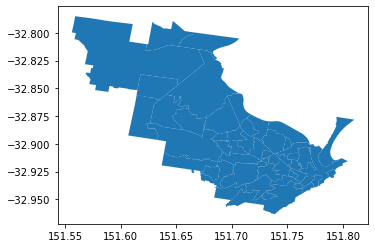

In [68]:
# Quick plot City of Newcaslte with included suburbs and their polygon borders
df2.plot()

In [69]:
# add NEIGHBORS column into the data 
df2["NEIGHBORS"] = None

# Loop through each row (suburb) and found othersharing border suburbs
for index, suburb in df2.iterrows():   
    # get 'not disjoint' suburbs
    suburbs = df2[~df2.geometry.disjoint(suburb.geometry)].NSW_LOCA_2.tolist()
    # remove own name from the list
    suburbs = [ name for name in suburbs if suburb.NSW_LOCA_2 != name ]
    # add names of suburbs as NEIGHBORS value
    df2.at[index, "NEIGHBORS"] = ", ".join(suburbs)

In [70]:
# Increase the visibility of each data column
pd.options.display.max_colwidth = 100
df2.head()

,NSW_LOCA_2,geometry,NEIGHBORS
0,MAYFIELD WEST,"POLYGON ((151.73345 -32.87974, 151.73286 -32.88246, 151.73284 -32.88254, 151.73270 -32.88319, 15...","MAYFIELD, WARABROOK, WARATAH WEST, MAYFIELD NORTH, WARATAH, SANDGATE"
1,BAR BEACH,"POLYGON ((151.77125 -32.93417, 151.77152 -32.93458, 151.77167 -32.93480, 151.77178 -32.93496, 15...","THE JUNCTION, THE HILL, COOKS HILL, MEREWETHER"
2,BIRMINGHAM GARDENS,"POLYGON ((151.69618 -32.88855, 151.69611 -32.88889, 151.69608 -32.88904, 151.69604 -32.88923, 15...","CALLAGHAN, JESMOND, WALLSEND, SHORTLAND"
4,MAYFIELD,"POLYGON ((151.73914 -32.88838, 151.73921 -32.88847, 151.73927 -32.88855, 151.73931 -32.88865, 15...","MAYFIELD WEST, MAYFIELD EAST, MAYFIELD NORTH, ISLINGTON, TIGHES HILL, WARATAH, GEORGETOWN"
7,RANKIN PARK,"POLYGON ((151.68678 -32.92029, 151.68711 -32.92060, 151.68756 -32.92029, 151.68761 -32.92026, 15...","ELERMORE VALE, NEW LAMBTON HEIGHTS"


## PART VI: DETERMINE THE PROPERTY PRICE OF EACH SUBURB (WITH INCOMPLETE DATA)

In [71]:
# The original data was taken from https://paigcrm.s3.amazonaws.com/2018/05/02/0d9101ce429fbd0c05c76f1d6d18db862bd57b4fe8b75b6930ebe0d88f927e18/Newcastle_Location_Report.pdf
# The relevent tabular pdf file was then converted to csv file
# CSV file was the uploaded public to download
!wget -q -O 'tabula-Newcastle-Report-September-2017.csv' https://www.dropbox.com/s/84fa5632u904dgb/tabula-Newcastle-Report-September-2017.csv?dl=0
print('Data downloaded!')

Data downloaded!


In [72]:
# Load the data into the dataframe
# The property data is based on the time: September 2017
new_house = pd.read_csv('tabula-Newcastle-Report-September-2017.csv')

# Format the column Median Units
new_house['Median Units'] = new_house['Median Units'].str[1:-1] # remove $ char at the beginning and ' ' char at the end
new_house['Median Units'] = new_house['Median Units'].str.replace(',','') # remove ',' char
new_house['Median Units'] = new_house['Median Units'].astype(int) # convert to int

In [73]:
# The data only provides the data for 28 suburbs
new_house = new_house[['Suburb','Median Units']]
new_house['Suburb'] = new_house['Suburb'].str.upper()
# len(new_house) # 28

In [74]:
# Create a new dataframe from the original df with uppercase suburb name
df_upper=pd.DataFrame(df['Suburb'].str.upper(),columns=['Suburb'])

In [75]:
# Merge the two dataframe together 
new_house_incomplete = df_upper.merge(new_house, how='left', on='Suburb')

# Set index with the suburb name
new_house_incomplete.set_index('Suburb',inplace=True)

# The merged data contains NaN value for suburbs with not provided property price
new_house_incomplete.head()

,Median Units
Suburb,
ADAMSTOWN,545000.0
ADAMSTOWN HEIGHTS,625000.0
BAR BEACH,NaN
BERESFIELD,NaN
BIRMINGHAM GARDENS,NaN


In [76]:
# Approach is to fill the missing data 
# The ASSUMPTION is the missing property price of each suburb is the available price average of neighbouring suburbs

while new_house_incomplete.isnull().values.any():

    for index, row in new_house_incomplete.iterrows():

        if np.isnan(row['Median Units']): 

            suburb = df2[df2['NSW_LOCA_2'] == index]
            test = suburb[['NEIGHBORS']].to_string(header=False,index=False)[1:]
            suburbs = test.split(', ')

            sum_suburb = 0
            count = 0

            for i in suburbs:

                if not np.isnan(new_house_incomplete.loc[i,'Median Units']): 

                    sum_suburb = sum_suburb + new_house_incomplete.loc[i,'Median Units']
                    count = count + 1

            if count != 0: row['Median Units'] = (sum_suburb / count).round(0)

In [77]:
# We have the complete property price data of every suburb in the City of Newcastle
new_house_complete = new_house_incomplete
new_house_complete.head()
# new_house_complete.to_csv('new_house_complete.csv')

,Median Units
Suburb,
ADAMSTOWN,545000.0
ADAMSTOWN HEIGHTS,625000.0
BAR BEACH,1111000.0
BERESFIELD,491500.0
BIRMINGHAM GARDENS,399000.0


## PART VII: GET PRIMARY SCHOOLS IN EACH SUBURBS WITH THEIR RATINGS

In [78]:
# Data source: http://bettereducation.com.au/school/Primary/nsw/nsw_primary_school_rating.aspx
# In order to get list of schools and ratings, 
# Method 1: MANNUALY type into EACH suburb name in search box
# Method 2: AUTOMATIC have each suburb filled in the form and get all relevant results

# MY APPROACH IS METHOD 2 since we have 51 suburbs, too many to manually collect results by filling each suburbs in the search form
# The script below is written to automate the process 
# However it takes 15 minutes to get the result so the script was commented



In [79]:
## Get the list of suburb to fill in the search form
## Remove 3 suburbs since during the run we found that there are no primary school in these suburbs 

# input_data = []
# for index, row in df.iterrows(): 
#     input_data.append(df.loc[index,'Suburb']+','+str(df.loc[index,'postcode']))
# unwanted = ['Callaghan,2308','Maryville,2293','Newcastle West,2302']
# input_data = [ele for ele in input_data if ele not in unwanted] 
# input_data

In [80]:
## Create two lists: schools and ratings 
## Create driver of Firefox and start filling the input into the search box
## Get the result of each input and store the relevant data into the two lists

# schools=[]
# ratings=[]  

# driver = webdriver.Firefox()
# driver.get("http://bettereducation.com.au/school/Primary/nsw/nsw_primary_school_rating.aspx")

# for element in test:
    
#     sleep(5)
    
#     searchbox = driver.find_element_by_id("ctl00_ContentPlaceHolder1_TextBoxLocality")
#     searchbox.clear()
#     searchbox.send_keys(element)
#     driver.find_element_by_id("ctl00_ContentPlaceHolder1_Button2").click()
#     driver.back()
    
#     print("Query Suburb: " + element)
    
#     sleep(5)
    
#     sug_html = driver.find_element_by_id('ctl00_ContentPlaceHolder1_GridView1').get_attribute('innerHTML')
#     soup=BeautifulSoup(sug_html, 'lxml')
    
#     tst = soup.find_all('tr')
    
#     for rows in tst[1:]:
        
#         school = rows.contents[1].contents[1].contents[0]
#         rating = rows.contents[2].contents[1].contents[0]
    
#         schools.append(school)
#         ratings.append(rating)
    
#     sleep(5)
    
# sleep(5)
# driver.quit()

In [81]:
# The list of schools and corresponding ratings were extracted and stored in a dataframe
# The data was then saved to csv file and uploaded to public for quicker access

# Download the data
!wget -q -O 'schools.csv' https://www.dropbox.com/s/3spsjkgpre3air8/schools.csv?dl=0
print('Data downloaded!')

Data downloaded!


In [82]:
# Stored in a dataframe
new_schools = pd.read_csv('schools.csv')

# Length of the schools
len(new_schools)

242

In [83]:
# dropping duplicate values since many same schools are listed in different suburbs
new_schools = new_schools.drop_duplicates(keep='first') 

# The complete list of primary schools in the City of Newcastle
# len(new_schools) # 60
# new_schools.to_csv('new_schools2.csv')
new_schools.head()

,School,Rating
0,"St James Primary School,Kotara South,NSW,2289",99
1,"Kotara South Public School,Kotara,NSW,2289",95
2,"Belair Public School,Adamstown,NSW,2289",94
3,"St Columba's Primary School,Adamstown,NSW,2289",86
4,"Garden Suburb Public School,Garden Suburb,NSW,2289",81


In [84]:
# Create two new column
new_schools['Primary_School'] = None
new_schools['Suburb'] = None
new_schools['Public'] = None

for index, row in new_schools.iterrows():
    
    new_schools.loc[index,'Primary_School'] = row['School'].split(',')[0]
    new_schools.loc[index,'Suburb'] = row['School'].split(',')[1].upper()
    
    if 'Public' in row['School'].split(',')[0]:

        new_schools.loc[index,'Public'] = 'Public'
    else: new_schools.loc[index,'Public'] = 'Private'
    


In [85]:
new_schools = new_schools[['Suburb','Primary_School','Rating','Public']]
new_schools.head()

,Suburb,Primary_School,Rating,Public
0,KOTARA SOUTH,St James Primary School,99,Private
1,KOTARA,Kotara South Public School,95,Public
2,ADAMSTOWN,Belair Public School,94,Public
3,ADAMSTOWN,St Columba's Primary School,86,Private
4,GARDEN SUBURB,Garden Suburb Public School,81,Public


In [86]:
new_schools = new_schools.drop(new_schools[new_schools['Rating']=='Not Rated'].index)
new_schools['Rating'] = new_schools['Rating'].astype(int)

## PART VIII: DETERMINE WHICH MOST SUITABLE SUBURBS TO LIVE IN THE CITY OF NEWCASTLE, NEW SOUTH WALES, AUSTRALIA

In [87]:
# I have kid who is going to primary school next year. I would love to live in suburb in which the schools nearby are good
# We prefer those schools with rating equal or more than 90 and they are public school. 
# Private schools might be considered in the future but fee are too expensive
top_new_public_schools = new_schools[(new_schools['Rating'] >= 90) & (new_schools['Public'] == 'Public')]
top_new_public_schools

,Suburb,Primary_School,Rating,Public
1,KOTARA,Kotara South Public School,95,Public
2,ADAMSTOWN,Belair Public School,94,Public
13,NEWCASTLE,Newcastle East Public School,96,Public
24,WALLSEND,Wallsend South Public School,90,Public
70,HAMILTON,Hamilton Public School,92,Public
92,MEREWETHER,Hamilton South Public School,97,Public
93,MEREWETHER,The Junction Public School,94,Public
94,MEREWETHER HEIGHTS,Merewether Heights Public School,93,Public
172,NEW LAMBTON,New Lambton Public School,98,Public
173,NEW LAMBTON,New Lambton South Public School,90,Public


In [88]:
# Merge the results dataframe with the property price data
best_suburbs = top_new_public_schools.merge(new_house_complete,how='left',on='Suburb')

In [89]:
# I consider to live in suburbs which I might buy a property in the future (currently renting is the only option)
# I think 600k-650k is the max threshold I can buy for a property
best_suburbs = best_suburbs[best_suburbs['Median Units'] < 650000]
best_suburbs

,Suburb,Primary_School,Rating,Public,Median Units
0,KOTARA,Kotara South Public School,95,Public,536000.0
1,ADAMSTOWN,Belair Public School,94,Public,545000.0
3,WALLSEND,Wallsend South Public School,90,Public,418000.0
4,HAMILTON,Hamilton Public School,92,Public,603000.0
8,NEW LAMBTON,New Lambton Public School,98,Public,625000.0
9,NEW LAMBTON,New Lambton South Public School,90,Public,625000.0
10,TIGHES HILL,Tighes Hill Public School,93,Public,549952.0


In [90]:
# Then merge the dataframe of suburbs belonging to cluster 1 and 5 (preferred groups)
best_suburbs = best_suburbs.merge(potential_suburbs,how='inner',on='Suburb')
best_suburbs.drop(['Public','Cluster Labels'],axis=1,inplace=True)
best_suburbs

,Suburb,Primary_School,Rating,Median Units,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,KOTARA,Kotara South Public School,95,536000.0,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
1,ADAMSTOWN,Belair Public School,94,545000.0,Fast Food Restaurant,Shopping Mall,Pub,Multiplex,Department Store,Convenience Store,Sandwich Place,Food Court,Juice Bar,Electronics Store
2,HAMILTON,Hamilton Public School,92,603000.0,Café,Pub,Bar,Gym,Italian Restaurant,Coffee Shop,Park,Pizza Place,Pool,Burger Joint
3,NEW LAMBTON,New Lambton Public School,98,625000.0,Pub,Café,Fast Food Restaurant,Sandwich Place,Department Store,Coffee Shop,Pizza Place,Italian Restaurant,Ice Cream Shop,Thai Restaurant
4,NEW LAMBTON,New Lambton South Public School,90,625000.0,Pub,Café,Fast Food Restaurant,Sandwich Place,Department Store,Coffee Shop,Pizza Place,Italian Restaurant,Ice Cream Shop,Thai Restaurant
5,TIGHES HILL,Tighes Hill Public School,93,549952.0,Café,Pub,Bar,Fast Food Restaurant,Convenience Store,Park,Gas Station,Gym,Supermarket,Sandwich Place


#### Among the 51 suburbs in the City of Newcastle, I prefer to live in one of 5 suburbs in the future. Priorities are as follows:
1. Tighes Hill
2. Kotara
3. Adamstown
4. New Lambton
5. Hamilton